# Defend against attribute attacks in face recognition models

## Create an attack and defence using attribute modification - hair color and style, pose, make-up and else.




#### create conde env

In [ ]:
%pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.7 MB/s eta 0:00:00


In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.12.0-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.12.0-Linux-x86_64.sh -b -f -p /usr/local/

--2023-01-20 15:44:23--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104996770 (100M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>] 100.13M   356MB/s    in 0.3s    

2023-01-20 15:44:24 (356 MB/s) - ‘Miniconda3-py37_4.12.0-Linux-x86_64.sh’ saved [104996770/104996770]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2022.3.29=h06a4308_1
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==1.15.0=py37hd667e15_1
    - ch

#### install prerequisites

In [ ]:
!yes | conda create -n stargan-v2 python=3.6.7
!yes | conda activate stargan-v2
!yes | conda install -y pytorch=1.4.0 torchvision=0.5.0 cudatoolkit=10.0 -c pytorch
!yes | conda install x264=='1!152.20180717' ffmpeg=4.0.2 -c conda-forge
!yes | pip install opencv-python==4.1.2.30 ffmpeg-python==0.2.0 scikit-image==0.16.2
!yes | pip install pillow==7.0.0 scipy==1.2.1 tqdm==4.43.0 munch==2.5.0

In [ ]:
'''General packages'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import cv2
from PIL import Image
import os
import time
from tqdm import *

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import glob
from datetime import datetime
import argparse
torch.manual_seed(42)
from facenet_pytorch import MTCNN, InceptionResnetV1


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# # %cd "/content/drive/MyDrive/HW_Gil_Shelly/Deep_Learning/final_project"

In [ ]:
! git clone https://github.com/shellyfra/Defend_against_attribute_attacks_in_face_recognition_models.git

Cloning into 'Defend_against_attribute_attacks_in_face_recognition_models'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 215 (delta 81), reused 151 (delta 30), pack-reused 0
Receiving objects: 100% (215/215), 10.44 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [ ]:
%cd Defend_against_attribute_attacks_in_face_recognition_models

/content/Defend_against_attribute_attacks_in_face_recognition_models


In [ ]:
from utils import train, set_parameter_requires_grad, eval_acc, imshow_no_normalization, get_params_to_update, imshow

In [ ]:
%cd StarGAN_with_our_changes

/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes


In [ ]:
# Download the STARGAN pretrained model on celebA-HQ
!bash download.sh stargan-pre-trained
# Download an attention pretrained model for the usage of the generation
!bash download.sh wing

for details.

--2023-01-20 15:50:37--  https://www.dropbox.com/s/96fmei6c93o8b8t/100000_nets_ema.ckpt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/96fmei6c93o8b8t/100000_nets_ema.ckpt [following]
--2023-01-20 15:50:37--  https://www.dropbox.com/s/raw/96fmei6c93o8b8t/100000_nets_ema.ckpt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf14ac390344778b3170942a149.dl.dropboxusercontent.com/cd/0/inline/B06kSmGwB5ZGSAShyLZiFGoB38_RaK8II8qpT_lYM1NfcB_pAbPBjyOpTtSPEs5A78aDCemReacwtgYWoN5JoM3ijBRgwTrMLEBYOYF29nzOqrjKoWw2nZJ6radBfUuYvgLr-NfRSPBmEvyvPKd5INkLXprfE7JcjBGUxBVXYuuJwA/file# [following]
--2023-01-20 15:50:38--  https://ucf14ac390344778b3170942a149.dl.dropboxusercontent.com/cd/0/inline/B06kSmGwB5ZGSAShyLZiFGoB38_RaK8II8qp

In [ ]:
# install our pre-trained models on celebA-HQ dataset (with / without augmentation and with attributes)
!bash download.sh models-weights

--2023-01-20 15:51:12--  https://docs.google.com/uc?export=download&confirm=t&id=1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_
Resolving docs.google.com (docs.google.com)... 108.177.125.102, 108.177.125.138, 108.177.125.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vdmgd31mksf1oo3djnfe17fv7m9a5qkh/1674229800000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=15043887-65bf-48e2-9a67-efe84a4273b1 [following]
--2023-01-20 15:51:13--  https://doc-14-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vdmgd31mksf1oo3djnfe17fv7m9a5qkh/1674229800000/05560778185249539437/*/1G5QNRswQjVNJ3gDTf0W8-vsiuFuVqDY_?e=download&uuid=15043887-65bf-48e2-9a67-efe84a4273b1
Resolving doc-14-08-docs.googleusercontent.com (doc-14-08-docs.googleusercontent.com)... 108.177.125.

In [ ]:
!bash download.sh celeba-hq-dataset

## Attack a specific identity on facenet model 

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('model_path', type=str, default=r'/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', help='the path to save model weights after training')
parser.add_argument('image_size', type=int, default=256, help='the image size to enter the face recognition model') # 256 is the size for FaceNet
parser.add_argument('lr', type=float, default=0.001, help='the learning rate used for train on CelebA data')
parser.add_argument('momentum', type=float, default=0.9, help='the momentum used for train on CelebA data')
parser.add_argument('train_celebA_num_epochs', type=int, default=20, help='the number of epochs used for the first train phase on CelebA data with no augmentation')
parser.add_argument('batch_size', type=int, default=16, help='train and test batch size')
parser.add_argument('num_workers', type=int, default=2, help='train and test num workers')
parser.add_argument('num_epochs', type=int, default=20, help='the number of epochs used for the first train phase on CelebA data with no augmentation')


args = parser.parse_args(args=['/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', '256', '1e-3', '0.9', '20', '16', '2', '20'])
print(args)

Namespace(batch_size=16, image_size=256, lr=0.001, model_path='/content/Defend_against_attribute_attacks_in_face_recognition_models/StarGAN_with_our_changes/', momentum=0.9, num_epochs=20, num_workers=2, train_celebA_num_epochs=20)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!python main.py --mode sample --num_domains 2 --resume_iter 100000 --w_hpf 1 \
               --checkpoint_dir expr/checkpoints/celeba_hq \
               --result_dir attack_objects\
               --src_dir attack_objects \
               --ref_dir attack_reference \
               --skip_rate 1


Start_sampling sample: 0
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
transforms_orig = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])

transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_classes = len(class_names) # clebA HQ sub dataset

celebA_facenet = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)

celebA_facenet.load_state_dict(state['net'])
celebA_facenet = celebA_facenet.to(device).eval()
celebA_facenet.classify = True

source_images = {108:'1919.jpg', 188: '12236.jpg', 563:'5103.jpg', 701: '11670.jpg', 80:'13726.jpg'}
reference_images = {129: '10178.jpg', }
id_to_attack = [f'attack_objects/{id}/{img_name}' for id, img_name in source_images.items()] 
reference_img_paths = [f'attack_reference/{id}/{img_name}' for id, img_name in reference_images.items()] 
id_after_attack = [f'attack_objects/{i}/new_image_{i}_{0}_{m}.jpg' for m, i in enumerate(source_images.keys()) for k, j in enumerate(reference_images.keys())]


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
def test_attack(state, celebA_facenet=celebA_facenet):
    num_classes = len(class_names) # clebA HQ sub dataset
    # print(num_classes)
    from facenet_pytorch import MTCNN, InceptionResnetV1
    facenet = InceptionResnetV1(pretrained='vggface2').to(device)
    facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

    facenet.load_state_dict(state['net'])
    facenet = facenet.to(device)
    facenet.classify = True
    facenet.eval()
    id_to_attack_imgs = [transforms_orig(Image.open(img_path).convert('RGB')) for img_path in id_to_attack]
    reference_imgs = [transforms_orig(Image.open(img_path).convert('RGB')) for img_path in reference_img_paths]
    id_after_attack_imgs = [transforms_orig(Image.open(img_path).convert('RGB')) for img_path in id_after_attack]
    # print(len(id_after_attack_imgs))
    input = torch.stack(id_to_attack_imgs)

    facenet.eval()
    facenet.classify = True

    img_probs = celebA_facenet(input.to(device))
    out0 = torchvision.utils.make_grid(input)
    imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}') # title=[x for x in img_probs.argmax(axis=1)]

    input = torch.stack(id_after_attack_imgs)
    img_probs = celebA_facenet(input.to(device))
    out0 = torchvision.utils.make_grid(input)
    imshow_no_normalization(out0, title=f'predicted class = {[class_names[prob.argmax().item()] for prob in img_probs]}') # title=[x for x in img_probs.argmax(axis=1)]

## Create augmentations for each image in the train dataset

In [ ]:
!python main.py --mode sample --resume_iter 100000 --w_hpf 1 \
               --checkpoint_dir expr/checkpoints/celeba_hq \
               --result_dir CelebA_HQ_facial_identity_dataset/train \
               --src_dir CelebA_HQ_facial_identity_dataset/train \
               --ref_dir defence_reference \
               --val_batch_size 4096 \
               --skip_rate 4


Start_sampling sample: 0
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
!python main.py --mode sample --resume_iter 100000 --w_hpf 1 \
               --checkpoint_dir expr/checkpoints/celeba_hq \
               --result_dir CelebA_HQ_facial_identity_dataset/test \
               --src_dir CelebA_HQ_facial_identity_dataset/test \
               --ref_dir defence_reference \
               --val_batch_size 4096 \
               --skip_rate 16

Start_sampling sample: 0
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
data_dir = './CelebA_HQ_facial_identity_dataset'
attr_aug_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
attr_aug_test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

attr_aug_train_dataloader = torch.utils.data.DataLoader(attr_aug_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
attr_aug_test_dataloader = torch.utils.data.DataLoader(attr_aug_test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

In [ ]:
celebA_facenet_attr_aug = InceptionResnetV1(pretrained='vggface2').to(device)
celebA_facenet_attr_aug = set_parameter_requires_grad(celebA_facenet_attr_aug, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
celebA_facenet_attr_aug.load_state_dict(state['net'])

params_to_update2 = get_params_to_update(celebA_facenet_attr_aug)
optimizer2 = torch.optim.SGD(params_to_update2, lr=args.lr, momentum=args.momentum)
criterion = nn.CrossEntropyLoss()

	 logits.weight
	 logits.bias


In [ ]:
attr_aug_train_losses, attr_aug_test_losses, attr_aug_train_acc, attr_aug_test_acc = train(celebA_facenet_attr_aug, criterion, optimizer2, 
                                                                       args.num_epochs, attr_aug_train_dataloader, attr_aug_train_dataset, attr_aug_test_dataloader,
                                                                        attr_aug_test_dataset, args.model_path, with_aug=True, free_text='attr', device=device)



395it [00:48,  8.20it/s]

[Train #0] Loss: 1.3176 Acc: 74.2513% Time: 48.2874s


[Test #0] Loss: 0.5818 Acc: 89.7586% Time: 61.2185s
==> Saving model ...


395it [00:48,  8.11it/s]

[Train #1] Loss: 1.1794 Acc: 76.8024% Time: 110.2134s


[Test #1] Loss: 0.5601 Acc: 90.2707% Time: 124.3561s
==> Saving model ...


395it [00:49,  7.93it/s]


[Train #2] Loss: 1.0801 Acc: 78.7038% Time: 174.4822s
[Test #2] Loss: 0.5314 Acc: 91.1485% Time: 187.5099s
==> Saving model ...


395it [00:48,  8.12it/s]

[Train #3] Loss: 1.0034 Acc: 80.6528% Time: 236.4261s


[Test #3] Loss: 0.5222 Acc: 91.3680% Time: 249.3186s
==> Saving model ...


395it [00:48,  8.12it/s]

[Train #4] Loss: 0.9500 Acc: 81.7462% Time: 298.1965s


[Test #4] Loss: 0.5043 Acc: 91.4411% Time: 311.2084s
==> Saving model ...


395it [00:51,  7.70it/s]

[Train #5] Loss: 0.8758 Acc: 83.7427% Time: 362.7823s


[Test #5] Loss: 0.4877 Acc: 92.0263% Time: 375.7272s
==> Saving model ...


395it [00:48,  8.07it/s]

[Train #6] Loss: 0.8455 Acc: 84.1071% Time: 424.9496s


[Test #6] Loss: 0.4862 Acc: 91.9532% Time: 437.7405s
==> Saving model ...


395it [00:48,  8.23it/s]

[Train #7] Loss: 0.7959 Acc: 85.0578% Time: 486.0185s


[Test #7] Loss: 0.4643 Acc: 92.3189% Time: 499.1076s
==> Saving model ...


395it [00:50,  7.78it/s]

[Train #8] Loss: 0.7605 Acc: 86.1512% Time: 550.1721s


[Test #8] Loss: 0.4713 Acc: 91.8800% Time: 563.0068s
==> Saving model ...


395it [00:47,  8.24it/s]

[Train #9] Loss: 0.7318 Acc: 86.8642% Time: 611.2023s


[Test #9] Loss: 0.4588 Acc: 92.4652% Time: 624.0598s
==> Saving model ...


395it [00:48,  8.15it/s]

[Train #10] Loss: 0.7058 Acc: 87.4822% Time: 672.7724s


[Test #10] Loss: 0.4490 Acc: 92.5384% Time: 685.5704s
==> Saving model ...


395it [00:51,  7.69it/s]

[Train #11] Loss: 0.6784 Acc: 87.5139% Time: 737.1867s


[Test #11] Loss: 0.4477 Acc: 92.0263% Time: 750.3109s
==> Saving model ...


395it [00:48,  8.18it/s]

[Train #12] Loss: 0.6573 Acc: 88.2111% Time: 798.8531s


[Test #12] Loss: 0.4439 Acc: 92.3189% Time: 811.7100s
==> Saving model ...


395it [00:47,  8.24it/s]

[Train #13] Loss: 0.6298 Acc: 89.0984% Time: 859.8974s


[Test #13] Loss: 0.4399 Acc: 92.4652% Time: 872.5143s
==> Saving model ...


395it [00:51,  7.74it/s]

[Train #14] Loss: 0.6249 Acc: 89.0509% Time: 923.8065s


[Test #14] Loss: 0.4406 Acc: 92.0995% Time: 936.5736s
==> Saving model ...


395it [00:47,  8.26it/s]

[Train #15] Loss: 0.6064 Acc: 89.2252% Time: 984.6791s


[Test #15] Loss: 0.4246 Acc: 92.3921% Time: 997.4024s
==> Saving model ...


395it [00:47,  8.28it/s]

[Train #16] Loss: 0.5886 Acc: 89.4153% Time: 1045.3664s


[Test #16] Loss: 0.4332 Acc: 92.7579% Time: 1058.0619s
==> Saving model ...


395it [00:48,  8.13it/s]

[Train #17] Loss: 0.5652 Acc: 90.0333% Time: 1106.9039s


[Test #17] Loss: 0.4265 Acc: 92.0263% Time: 1122.3501s
==> Saving model ...


395it [00:47,  8.25it/s]

[Train #18] Loss: 0.5626 Acc: 90.1442% Time: 1170.4725s


[Test #18] Loss: 0.4920 Acc: 90.7827% Time: 1183.4392s
==> Saving model ...


395it [00:47,  8.24it/s]

[Train #19] Loss: 0.5296 Acc: 90.6988% Time: 1231.6292s


[Test #19] Loss: 0.4382 Acc: 92.2458% Time: 1244.5665s
==> Saving model ...
==> Finished Training ...


In [ ]:
attr_aug_test_acc = np.array([t.cpu().item() for t in attr_aug_test_acc])
attr_aug_train_acc = np.array([t.cpu().item() for t in attr_aug_train_acc])
attr_aug_test_losses = np.array(attr_aug_test_losses)
attr_aug_train_losses = np.array(attr_aug_train_losses)

np.save(args.model_path + r'/models/attr_aug_test_acc.npy', attr_aug_test_acc)
np.save(args.model_path + r'/models/attr_aug_train_acc.npy', attr_aug_train_acc)
np.save(args.model_path + r'/models/attr_aug_test_losses.npy', attr_aug_test_losses)
np.save(args.model_path + r'/models/attr_aug_train_losses.npy', attr_aug_train_losses)

In [ ]:
# if nessecary
attr_aug_test_acc = np.load(args.model_path + r'/models/attr_aug_test_acc.npy')
attr_aug_train_acc = np.load(args.model_path + r'/models/attr_aug_train_acc.npy')
attr_aug_test_losses = np.load(args.model_path + r'/models/attr_aug_test_losses.npy')
attr_aug_train_losses = np.load(args.model_path + r'/models/attr_aug_train_losses.npy')

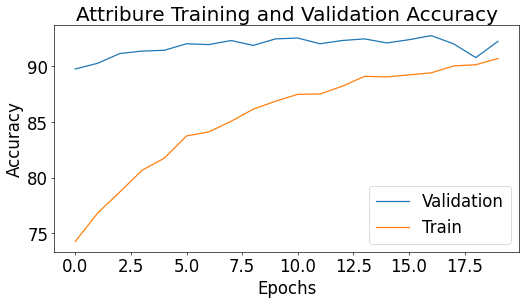

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Attribure Training and Validation Accuracy")
plt.plot(attr_aug_test_acc,label="Validation")
plt.plot(attr_aug_train_acc,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

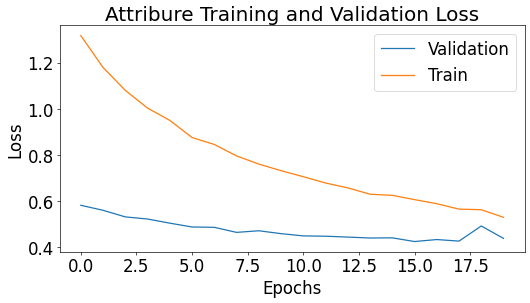

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Attribure Training and Validation Loss")
plt.plot(attr_aug_test_losses,label="Validation")
plt.plot(attr_aug_train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ***The identities BEFORE the defence***

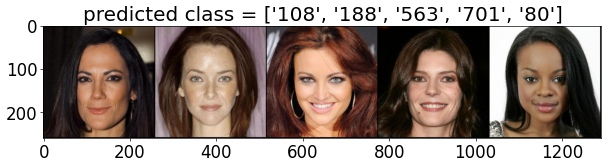

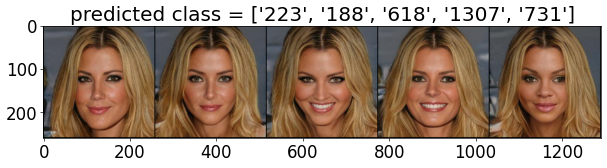

In [ ]:
model_name = 'CelebA_HQ_Facenet_without_aug.pth'
path_name = f'{args.model_path}/models/{model_name}'
old_state = torch.load(path_name, map_location=device)
test_attack(old_state)


# ***The identities AFTER the defence***

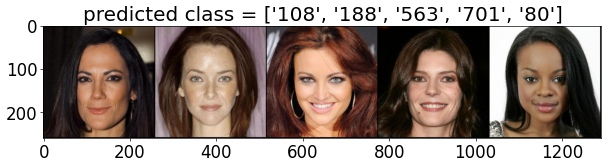

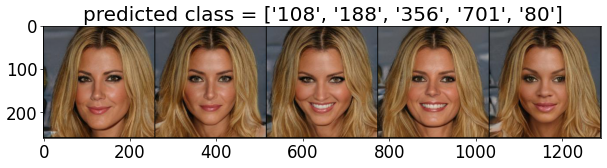

In [ ]:
model_name = 'CelebA_HQ_Facenet_with_aug_attribute.pth'
path_name = f'{args.model_path}/models/{model_name}'
new_state = torch.load(path_name, map_location=device)
test_attack(new_state)

In [ ]:
def model_pre_proccess(state):
    from facenet_pytorch import MTCNN, InceptionResnetV1
    facenet = InceptionResnetV1(pretrained='vggface2').to(device)
    facenet = set_parameter_requires_grad(celebA_facenet, num_classes)

    facenet.load_state_dict(state['net'])
    facenet = facenet.to(device)
    facenet.classify = True
    facenet.eval()
    return facenet

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_without_aug = InceptionResnetV1(pretrained='vggface2').to(device)
model_without_aug = set_parameter_requires_grad(model_without_aug, num_classes)

model_name = 'CelebA_HQ_Facenet_without_aug.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
model_without_aug.load_state_dict(state['net'])
model_without_aug = model_without_aug.to(device)

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_with_aug = InceptionResnetV1(pretrained='vggface2').to(device)
model_with_aug = set_parameter_requires_grad(model_with_aug, num_classes)

model_name = 'CelebA_HQ_Facenet_with_aug_scratch.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
model_with_aug.load_state_dict(state['net'])
model_with_aug = model_with_aug.to(device)

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
model_with_attr = InceptionResnetV1(pretrained='vggface2').to(device)
model_with_attr = set_parameter_requires_grad(model_with_attr, num_classes)

model_name = 'CelebA_HQ_Facenet_aug_attr_epoch16_acc_92.7579_20_01_2023_17_05_09.pth'
state = torch.load(f'{args.model_path}/models/{model_name}', map_location=device)
model_with_attr.load_state_dict(state['net'])
model_with_attr = model_with_attr.to(device)

In [ ]:
# model_name1 = 'CelebA_HQ_Facenet_without_aug.pth'
# state_without_aug = torch.load(f'{args.model_path}/models/{model_name1}', map_location=device)
# model_without_aug = model_pre_proccess(state_without_aug)

# model_name2 = 'CelebA_HQ_Facenet_with_aug_fine_tune.pth'
# state_with_aug = torch.load(f'{args.model_path}/models/{model_name2}', map_location=device)
# model_with_aug = model_pre_proccess(state_with_aug)

# model_name3 = 'CelebA_HQ_Facenet_with_aug_attribute.pth'
# state_with_attr = torch.load(f'{args.model_path}/models/{model_name3}', map_location=device)
# model_with_attr = model_pre_proccess(state_with_attr)

In [ ]:
print("evaluate on fine-tuned not augmented data:")
eval_acc(model_without_aug, attr_aug_test_dataloader, device)

print("evaluate on fine-tuned augmented data:")
eval_acc(model_with_aug, attr_aug_test_dataloader, device)

print("evaluate on attribute change data:")
eval_acc(model_with_attr, attr_aug_test_dataloader, device)

evaluate on fine-tuned not augmented data:
Loss: 10.3717 Acc: 88.1541% 
evaluate on fine-tuned augmented data:
Loss: 10.1298 Acc: 87.7180% 
evaluate on attribute change data:
Loss: 6.8863 Acc: 92.1512% 


(6.886312925538351, tensor(92.1512, device='cuda:0'))